# Labelling training data
Given the relatively small size of our training data, we manually labelled the training data.

In [ ]:
# Install imaging library Pillow
%pip install pillow

In [ ]:
import os
from PIL import Image
import xml.etree.ElementTree as ET

In [ ]:
# Training data from Kaggle
unlabeled_data_folder = os.path.join("Data", "train")

# XML files created by LabelIMG
data_labels_folder = os.path.join("Labelled_Training_Data")

# Cropped images sorted by coin type
extracted_data_folder = os.path.join("Extracted_Training_Data")
os.makedirs(extracted_data_folder, exist_ok=True)

In [ ]:
def crop_and_save_image(input_image_path, output_folder, object_list):
    # Open the input image
    with Image.open(input_image_path) as img:
        for index, object in enumerate(object_list):
            # Crop the image
            name = object['name']
            cropped_img = img.crop((int(object['xmin']), int(object['ymin']), int(object['xmax']), int(object['ymax'])))
            output_coin_type = os.path.join(output_folder, name)
            # Ensure the output folder exists
            os.makedirs(output_coin_type, exist_ok=True)
            
            # Construct the output image path, weird naming to avoid duplicates from same image, index placed before filetype
            image_name = os.path.basename(input_image_path[:-4]) + '_' + str(index) + '.JPG'
            output_image_path = os.path.join(output_coin_type, image_name)
            
            # Save the cropped image
            cropped_img.save(output_image_path)
            print(f'Cropped image saved to: {output_image_path}')

In [ ]:
def read_xml_file_content(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    object_list = []
    for object in root.findall('object'):
        d = dict()
        d['name'] = object.findtext('name')
        bounding_box = object.find('bndbox')
        d['xmin'] = bounding_box.findtext('xmin')
        d['ymin'] = bounding_box.findtext('ymin')
        d['xmax'] = bounding_box.findtext('xmax')
        d['ymax'] = bounding_box.findtext('ymax')
        object_list.append(d)

    return object_list

In [ ]:
for folder in os.listdir(unlabeled_data_folder):
    label_folder = os.path.join(data_labels_folder, folder)
    folder = os.path.join(unlabeled_data_folder, folder)
    for image in os.listdir(folder):
        # Find corresponding XML_file
        for label_file in os.listdir(label_folder):
            if (image[:-4] in label_file):
                label_filepath = os.path.join(label_folder, label_file)
                image_filepath = os.path.join(folder, image)
                object_list = read_xml_file_content(label_filepath)

                crop_and_save_image(image_filepath, extracted_data_folder, object_list)

# Image segmentation

## Attempt with classical segmentation

In [ ]:
# Code here

## Training ResNet-50 for object localization

Run the next cell if you want to re-train the model on custom data. The model will be saved as "coin_detector.pth" in the root folder.

**IMPORTANT:** The folder structure of the training dataset must follow exactly:
```
dataset
├── images
│   ├── L1010277.JPG
├── annotations
│   ├── L1010277 [1].xml
```


### Prepare the labelled training dataset into the required format

In [ ]:
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from PIL import Image


In [ ]:
# File folder organization
unlabeled_data_folder = os.path.join("Data", "train")

data_labels_folder = os.path.join("Labelled_Training_Data")

coin_detection_dataset = os.path.join("dataset")
coin_detection_images = os.path.join("dataset", "images")
coin_detection_annotations = os.path.join("dataset", "annotations")
os.makedirs(coin_detection_dataset, exist_ok=True)
os.makedirs(os.path.join(coin_detection_dataset, "images"), exist_ok=True)
os.makedirs(os.path.join(coin_detection_dataset, "annotations"), exist_ok=True)


In [ ]:
# Data/train/folder
for folder in os.listdir(unlabeled_data_folder):
    # Labelled_Training_Data/label_folder
    label_folder = os.path.join(data_labels_folder, folder)
    # folder = path to folder
    folder = os.path.join(unlabeled_data_folder, folder)
    for image in os.listdir(folder):
        # Find corresponding XML_file
        for label_file in os.listdir(label_folder):
            # Ex: L1010277.JPG --> L1010277
            if (image[:-4] in label_file):
                label_filepath = os.path.join(label_folder, label_file)
                image_filepath = os.path.join(folder, image)
                shutil.copy2(label_filepath, coin_detection_annotations)
                shutil.copy2(image_filepath, coin_detection_images)

In [ ]:
# Parser for data
class CoinDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


# Use a pre-trained Faster R-CNN model, pre-trained on ImageNet
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background and coin
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Data transforms
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Train on custom dataset

Run the next cell if you want to train the model on the custom (coins) dataset. 

In [ ]:
# Load the dataset
dataset = CoinDataset("dataset/", transforms=transforms)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

# Fine-tune the model based on our labelled training data
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("Beginning epoch", epoch + 1)
    for i, (images, targets) in enumerate(data_loader, 0):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        if i % 10 == 9:  # Print every 10 batches
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(data_loader)}], Loss: {running_loss/10:.4f}"
            )
            running_loss = 0.0

print("Training finished.")

# Save the trained model
torch.save(model.state_dict(), "coin_detector.pth")

### (Optional) Load an existing model

Uncomment and run the next cell if you already have a trained model, and skip the above cell.

In [ ]:
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from PIL import Image

# Load the trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background and coin
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("coin_detector.pth"))

### Perform object localization on test images

**IMPORTANT:** The folder structure of input test images must follow exactly:
```
data
├── test
│   ├── L1010277.JPG
│   ├── L1010239.JPG
```
And the folder structure of output images will be:
```
output
├── L0000000.JPG                        <---------------- This is a directory
│   ├── 1920_1519_2595_2181.jpg         <---------------- This is an image of the 1st cropped coin, belonging to L0000000.JPG
│   ├── 2780_2159_3326_2685.jpg         <---------------- This is an image of the 2nd cropped coin, belonging to L0000000.JPG
├── L0000001.JPG                        
│   ├── 1920_1519_2595_2181.jpg         
│   ├── 2780_2159_3326_2685.jpg         
```
If an "output" folder already exists, it will get overwritten.

In [ ]:
# Perform inference on test images
model.eval()
test_data_path = "Data/test"

os.makedirs("output", exist_ok=True)
for img_name in os.listdir(test_data_path):
    img_path = os.path.join(test_data_path, img_name)
    # Check if the file is an image
    if not img_name.endswith(".JPG") and not img_name.endswith(".jpg"):
        continue
    img = Image.open(img_path).convert("RGB")
    img_tensor = transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
    # Create a directory for each image, where cropped coins will be saved
    os.mkdir(f"output/{img_name}")
    boxes = outputs[0]["boxes"].cpu().numpy()
    # Crop coins from current image
    for box in boxes:
        xmin, ymin, xmax, ymax = box.astype(int)
        coin = img.crop((xmin, ymin, xmax, ymax))
        cropped_coin_path = os.path.join(
            f"output/{img_name}", f"{xmin}_{ymin}_{xmax}_{ymax}.jpg"
        )
        coin.save(cropped_coin_path)

# Classification

## Importing data

In [2]:
import os
import cv2 as cv

images_classes_path = "./Extracted_Training_data"
image_classes_list = os.listdir(images_classes_path)
num_classes = len(image_classes_list)
print("total {} classes".format(num_classes))

test_images_path = "output"
images_dict = {}
image_name_list = os.listdir(test_images_path)
for image_folder in image_name_list:
    images_dict[image_folder] = []
    images_path = os.path.join(test_images_path, image_folder)
    # Check if the path is a directory
    if not os.path.isdir(images_path):
        continue
    for image in os.listdir(images_path):
        path_to_coin_image = os.path.join(images_path, image)
        images_dict[image_folder].append(path_to_coin_image)
num_images = len(image_name_list)
print("total {} test images".format(num_images))

total 16 classes
total 162 test images


## Data augmentation

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
!rm -rf ./logs/

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np


### Import Required Libraries
This section imports the necessary libraries for image processing and augmentation `ImageDataGenerator`and related functions from `tensorflow.keras.preprocessing.image` are used for loading and augmenting images. The `os` module handles directory operation, and `tqdm` provides a progress bar for the augmentation process.

In [4]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
import os
from tqdm import tqdm
import random

### Initialize the ImageDataGenerator

An instance of `ImageDataGenerator`is created with specific augmentation parameters. The purpose of this data augmentation is to artificially expand the training dataset by generating new, altered versions of the existing coin images. This is particularly beneficial since our original training dataset is small, so augmentation will help to prevent overfitting and improve the model's ability to generalize to new data. 

For this task, the chosen augmentations are Rescaling, Rotation, Brightness Adjustment and Zoom. Rescaling of pixel values from [0,255] range to [0,1] is done to facilitate faster convergence during training. We apply a random rotation of up to 90 degrees as well, this is to make the model robust to changes in orientation, improving its ability to recognize coins regardless of rotation. Since lighting conditions vary slightly in the training data a brightness adjustment is also implemented. Finally a slight zoom in is implemented since the segmentation algorithm can cut of some edges of coins and therefore preparing the model for that in the training data makes generalize better to the test dataset.


In [5]:

# Create the directories to save the augmented images
augmented_data_path = 'path_to_save_augmented_images'
os.makedirs(augmented_data_path, exist_ok=True)

crazy_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
)


### Augment and Save Images
This loop iterates over each class directory and each image within that directory. Each image is loaded and converted to an array. The `datagen.flow` function generates augmented images which are saved to the specified directory.

In [ ]:
# Set the number of augmented images to generate per original image
num_augmented_images = 10

# Load the original images
original_data_path = images_classes_path

# Calculate the total number of files
all_files = sum([len(files) for r, d, files in os.walk(original_data_path)])
pbar = tqdm(total=all_files * num_augmented_images, desc="Augmenting images")

for class_dir in os.listdir(original_data_path):
    class_path = os.path.join(original_data_path, class_dir)
    save_class_path = os.path.join(augmented_data_path, class_dir)
    os.makedirs(save_class_path, exist_ok=True)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        
        # Generate and save augmented images
        i = 0
        for batch in crazy_datagen.flow(x, batch_size=1, save_to_dir=save_class_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            pbar.update(1)
            if i >= num_augmented_images:
                break

pbar.close()

### Define Data generators for Training and validation
Two data generators are defined: one for training and one for validation. The images are rescaled, and the dataset is split into training and validation subsets. The images are resized to 224x224 picels, and a batch size of 32 is used. Different batch sizes were tested, but 32 was found to be a suitable batch size because of the small dataset.

In [6]:
# Define the data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = datagen.flow_from_directory(
    augmented_data_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset="training"
)

val_generator = datagen.flow_from_directory(
    augmented_data_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# # Test data generator remains the same
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_images_path,
#     target_size=(224, 224),
#     shuffle=False,
#     batch_size=1,
#     class_mode='categorical'
# )

# # Get filenames and number of samples
# filenames = test_generator.filenames
# nb_samples = len(filenames)



Found 2657 images belonging to 16 classes.
Found 1124 images belonging to 16 classes.


### Validate Data Generators

In [7]:
# Print a batch for verification
x_batch, y_batch = next(train_generator)
print(f"Batch x_shape: {x_batch.shape}, Batch y_shape: {y_batch.shape}")

# Verify the data generators
train_batch = next(iter(train_generator))
val_batch = next(iter(val_generator))
print(train_batch[0].shape, train_batch[1].shape)
print(val_batch[0].shape, val_batch[1].shape)

print(f"Steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation steps: {val_generator.samples // val_generator.batch_size}")

Batch x_shape: (16, 224, 224, 3), Batch y_shape: (16, 16)
(16, 224, 224, 3) (16, 16)
(16, 224, 224, 3) (16, 16)
Steps per epoch: 166
Validation steps: 70


## Model configuration using Xception

In [8]:
import keras
from keras.layers import Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

### Loading and Customizing InceptionV3 Base Model
The pre-trained InceptionV3 model is loaded with weights from ImageNet, excluding the top fully connected layers. This allows us to customize the output layers for the coin classification task. 

In [9]:
# from keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception
# base_model = InceptionV3(include_top=False, # Since we will create our own
#                     weights='imagenet', 
#                     input_shape=(224, 224, 3))
# base_model.summary()

# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

### Building the Custom Output Layers

The ouput of the IncdeptionV3 base model is passed through a series of custom layers:

**Flatten:** Converst the feature maps to a 1D feature vector\
**BatchNormalization:** Normalizes the activations to improve training stability\
**Dense (512 units):** Fully connected layer with ReLy activation\
**Dropout (50%):** Regularization technique to prevent overfitting\
**Dense (num_classes):** Output layer with softmax actiavtion for the final coin classification

In [10]:
# x = inceptionv3_base.output
# # x = Flatten()(x)
# # x = BatchNormalization()(x)
# # x = Dense(512, activation='relu')(x)
# # x = Dropout(rate = .5)(x)
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
# predictions = Dense(num_classes, activation='softmax')(x)

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

### Freezing of Base layers

This block freezes all the layer except the last 7 in order to retrain the pre-trained weights during initial training. The last 7 layers remain trainable to fine-tune them for coin classification. 

In [12]:
# Freezing in order to only train the last 7 layers
for layer in model.layers[:]:
    layer.trainable = True
for layer in model.layers[:-10]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.summary()


0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

### Compiling the Model
The model is compiled with the Adam optimizer, which is chosen for its efficiency and adaptability. The learning rate is set to 0.0001. The loss function is categorical cross-entropy, which is suitibla for the multi-class coin classification. 

In [13]:
optimizer = Adam(learning_rate=0.0001)
# optimizer = SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Setting Up Callbacks
Three callbacks are defined to enhance the training process:

**ModelCheckpoint:** Saves the model with the best validation accuracy\
**TensorBoard:** Logs training metrics for visualization.\
**EarlyStopping:** Stops training if the validation does not improve for 6 consecutive epochs, restoring the best weights.\

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint('model.keras',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


my_callbacks = [checkpoint, tensorboard_callback, early_stopping_callback]

### Training the Model

In [15]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          callbacks=my_callbacks)
print('Training done!')


Epoch 1/15


2024-05-29 00:50:20.259232: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


167/167 [==============================] - 117s 696ms/step - loss: 2.1687 - accuracy: 0.3414 - val_loss: 1.1930 - val_accuracy: 0.6290
Epoch 2/15
167/167 [==============================] - 115s 690ms/step - loss: 1.1648 - accuracy: 0.6255 - val_loss: 0.6555 - val_accuracy: 0.7767
Epoch 3/15
167/167 [==============================] - 110s 660ms/step - loss: 0.7752 - accuracy: 0.7520 - val_loss: 0.4480 - val_accuracy: 0.8594
Epoch 4/15
167/167 [==============================] - 114s 683ms/step - loss: 0.5415 - accuracy: 0.8186 - val_loss: 0.3326 - val_accuracy: 0.8941
Epoch 5/15
167/167 [==============================] - 113s 675ms/step - loss: 0.3889 - accuracy: 0.8713 - val_loss: 0.2629 - val_accuracy: 0.9208
Epoch 6/15
167/167 [==============================] - 110s 658ms/step - loss: 0.3074 - accuracy: 0.9082 - val_loss: 0.2289 - val_accuracy: 0.9306
Epoch 7/15
167/167 [==============================] - 109s 653ms/step - loss: 0.2449 - accuracy: 0.9259 - val_loss: 0.1802 - val_accura

In [16]:
model_label = "gap_dense-2_bs-16.h5"
model.save(model_label)

In [17]:
for layer in model.layers[:]:
    layer.trainable = True

In [18]:
params = model.fit(train_generator, 
                                validation_data=val_generator, 
                                epochs=30,
                                callbacks=my_callbacks)

Epoch 1/30
167/167 [==============================] - 113s 675ms/step - loss: 0.0429 - accuracy: 0.9902 - val_loss: 0.1198 - val_accuracy: 0.9591
Epoch 2/30
167/167 [==============================] - 114s 685ms/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 0.1092 - val_accuracy: 0.9626
Epoch 3/30
167/167 [==============================] - 111s 665ms/step - loss: 0.0272 - accuracy: 0.9925 - val_loss: 0.2200 - val_accuracy: 0.9253
Epoch 4/30
167/167 [==============================] - 113s 675ms/step - loss: 0.0400 - accuracy: 0.9868 - val_loss: 0.1302 - val_accuracy: 0.9573
Epoch 5/30
167/167 [==============================] - 113s 675ms/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.1269 - val_accuracy: 0.9591
Epoch 6/30
167/167 [==============================] - 113s 676ms/step - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.1115 - val_accuracy: 0.9644
Epoch 7/30
167/167 [==============================] - 110s 661ms/step - loss: 0.0307 - accuracy: 0.9917 - val_loss: 0.1057 -

In [ ]:
model_label = "gap_dense-2_bs-16_unfroze-all.h5"
model.save(model_label)

## Plot accuracies and losses

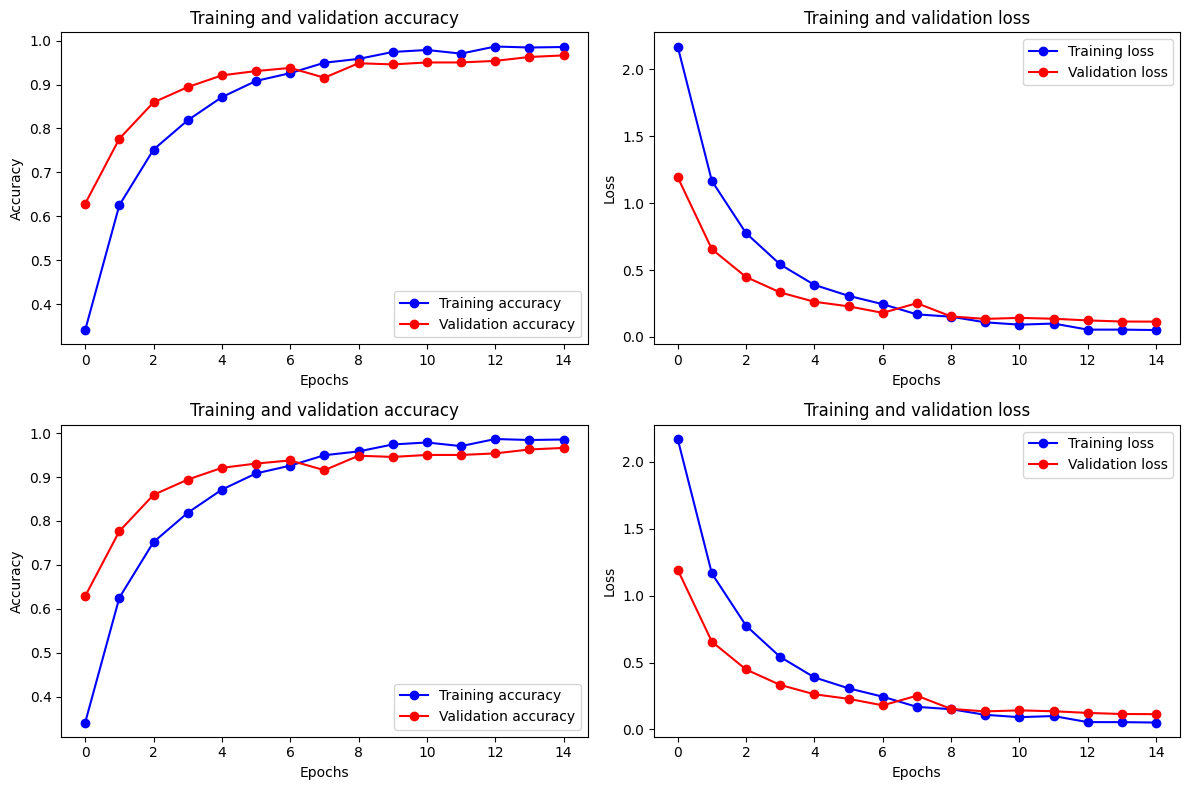

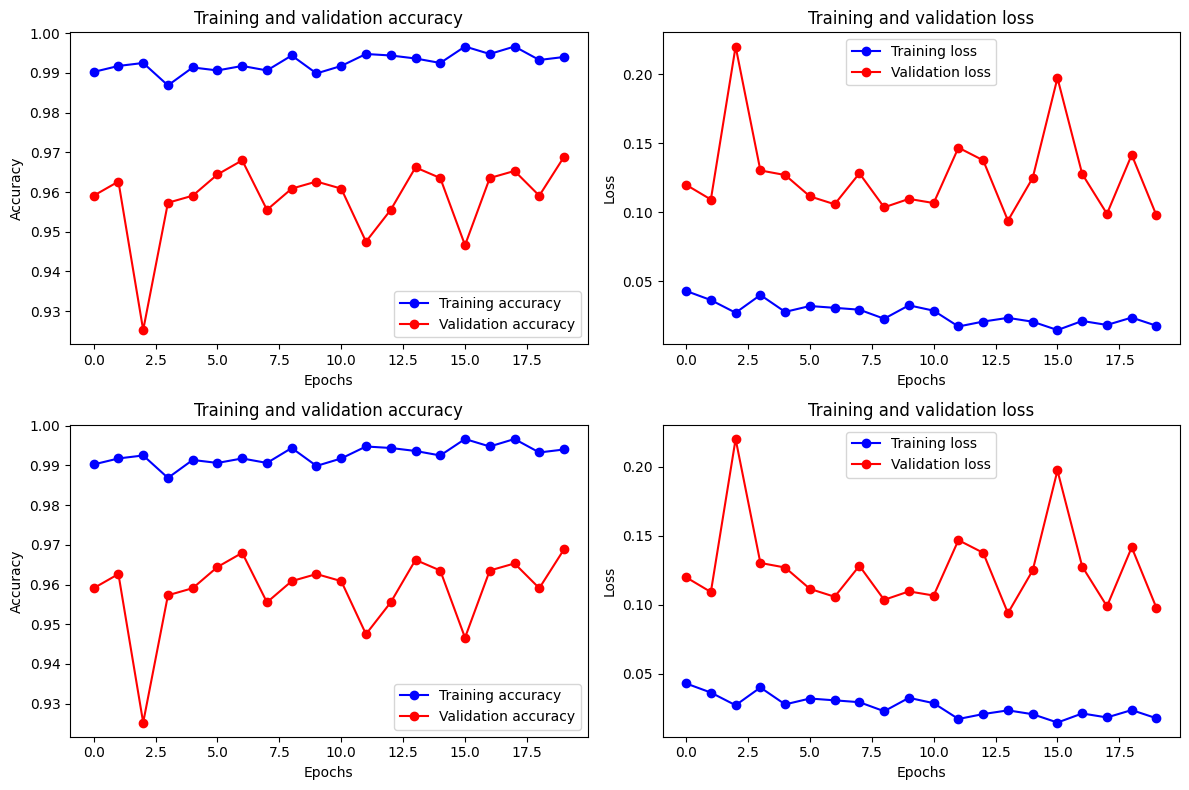

In [19]:
def plot_history(history):
    acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' is the History object returned from model.fit
plot_history(history)
plot_history(params)

In [20]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
ImportError: dlopen(/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so, 0x0002): tried: '/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (no such file), '/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
thread '<unnamed>' panicked at 'Python API call failed', /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_905z2r5rpq/croot/cryptography_1694211573866/_build_env/.cargo.Darwin/registry/src/index.crates.io-6f17d22bba15001f/pyo3-0.18.3/src/err/mod.rs:790:5
note: r

In [21]:
import os
import time
import subprocess
from IPython.display import display, HTML

os.system('pkill -f "tensorboard"')
subprocess.Popen(["tensorboard", "--logdir", "logs/fit"])
time.sleep(5)
display(HTML(f'<a href="http://localhost:6006" target="_blank">Open TensorBoard</a>'))

ImportError: dlopen(/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so, 0x0002): tried: '/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (no such file), '/Users/ombhandari/anaconda3/envs/iapr/lib/python3.9/site-packages/_cffi_backend.cpython-39-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
thread '<unnamed>' panicked at 'Python API call failed', /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_905z2r5rpq/croot/cryptography_1694211573866/_build_env/.cargo.Darwin/registry/src/index.crates.io-6f17d22bba15001f/pyo3-0.18.3/src/err/mod.rs:790:5
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
Tr

## Use model on given test images


In [22]:
def predict_images(path, verbose=False, show_image=False):
    # Load and display the image
    img = mpimg.imread(path)

    if show_image:
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.show()

    # Preprocess the image
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input

    # Predict the probabilities
    probabilities = model.predict(image, verbose=0)

    # Get class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}

    # Prepare data for a nice display
    sorted_indices = np.argsort(probabilities[0])[::-1]
    results = [(class_labels[i], probabilities[0][i]) for i in sorted_indices]

    # Print sorted probabilities and their corresponding class labels
    if verbose:
        print("Class".ljust(15), "Probability")
        print("-" * 30)
        for label, prob in results:
            print(f"{label.ljust(15)} : {prob:.4f}")

    # Return the class label with the highest probability
    return results[0][0]

In [23]:
# For processing submission
import pandas as pd

# This will used as a template to build the submission.
if not os.path.exists("sample_submission.csv"):
    raise FileNotFoundError("sample_submission.csv not found!")
submission = pd.read_csv("sample_submission.csv")
submission.head()

# Perform prediction on all test images.
for key in images_dict:
    labels_count = {key: 0 for key in image_classes_list}
    for coin_path in images_dict[key]:
        predicted_class = predict_images(coin_path)
        labels_count[predicted_class] += 1

    row_to_write = submission.loc[submission["id"] == key[:-4]]

    for label in labels_count:
        row_to_write[label] = labels_count[label]

    submission.loc[submission["id"] == key[:-4]] = row_to_write


# Save the submission
submission.to_csv("submission_test.csv", index=False)

/var/folders/yd/qzq97j0x0sb4t5krjj2jnhpw0000gn/T/ipykernel_33886/2923989941.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_to_write[label] = labels_count[label]
/var/folders/yd/qzq97j0x0sb4t5krjj2jnhpw0000gn/T/ipykernel_33886/2923989941.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_to_write[label] = labels_count[label]
/var/folders/yd/qzq97j0x0sb4t5krjj2jnhpw0000gn/T/ipykernel_33886/2923989941.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Confusion matrix on validation set

71/71 [==============================] - 33s 453ms/step


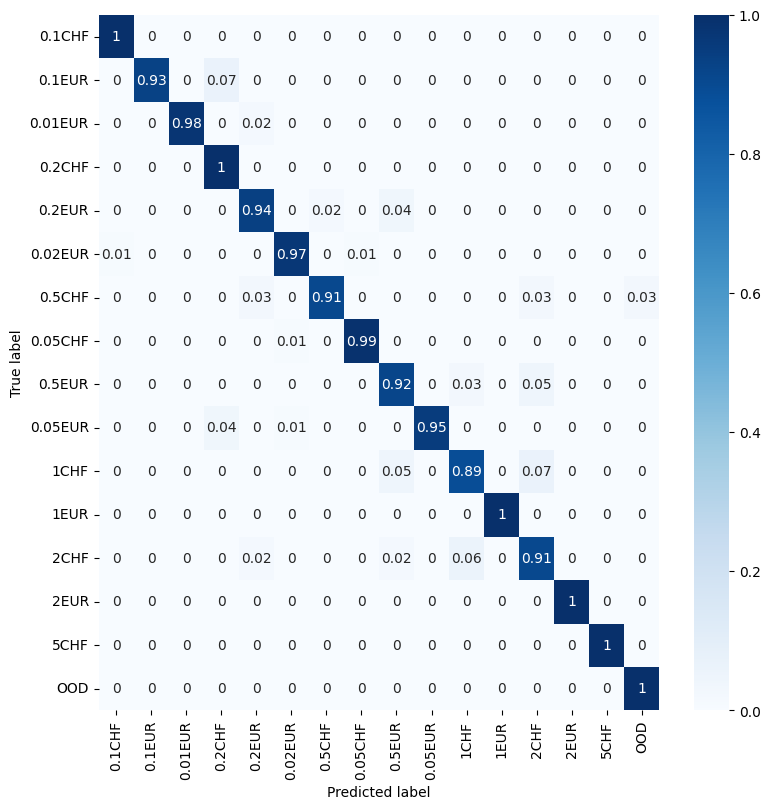

In [24]:
import pandas as pd
import seaborn as sns

Y_pred = model.predict(val_generator, 1167//32+1)
y_pred = np.argmax(Y_pred, axis=1)
cfm = confusion_matrix(val_generator.classes, y_pred)
cfm = np.around(cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis], decimals=2)
classes = ['0.1CHF', '0.1EUR', '0.01EUR', '0.2CHF', '0.2EUR', '0.02EUR', '0.5CHF', '0.05CHF', '0.5EUR', '0.05EUR', '1CHF', '1EUR', '2CHF', '2EUR', '5CHF', 'OOD']
cfm_pd = pd.DataFrame(cfm, index = classes, columns = classes)
figure = plt.figure(figsize=(8,8))
sns.heatmap(cfm_pd, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
